#  Calibration Image Master Creation notebook

This notebook calibrates Bias images, Dark images and Flat images and combines them into their respective Master files

Made by: Harlan Shaw <harlan.shaw@ucalgary.ca>

## Required Python packages:
[Astropy](https://www.astropy.org/)

[CCDProc](https://ccdproc.readthedocs.io/en/latest/index.html)

[Astro-SCRAPPY](https://github.com/astropy/astroscrappy)

It's recommended you download and install [Anaconda](https://www.anaconda.com/products/individual#Downloads) as this contains a Python environment and Astropy.

You will need to install CCDProc using the Conda install command: `conda install -c conda-forge ccdproc`

This will also install Astropy and Astro-SCRAPPY if not already installed.

## Citations:
This project uses:

[Astropy](https://www.astropy.org/acknowledging.html)

[CCDProc](https://ccdproc.readthedocs.io/en/latest/citation.html)

[Astro-SCRAPPY](https://github.com/astropy/astroscrappy)



## How to Use

It's recommended you click "Run All Cells" to run this notebook, but you may optionally run each cell individually.

This notebook requires the location of your raw bias images as either a full location or as a relative path if you have the bias images in the folder that this notebook is located in.

Example:

Full location: C:\path\to\bias

Relative: path\to\bias



# Setup

All variables are set up in this cell. If this cell is not run, the program will not run.

In [71]:
from pathlib import Path
from astropy.nddata import CCDData
from astropy.stats import mad_std
from astropy.units import adu, second
from astropy.wcs import FITSFixedWarning
from ccdproc import ImageFileCollection, combine, subtract_bias, subtract_dark
import matplotlib.pyplot as plt
import numpy as np
import logging
import warnings

warnings.filterwarnings("ignore", category=FITSFixedWarning)


GIGABYTE = 1e9 # 1 billion bytes
MEMORY_LIMIT = 10*GIGABYTE

data_directory = Path(".") # directory that notebooks are in.
DARKS_PATH = data_directory / "Darks_12C"
BIAS_PATH = data_directory / "Bias"
FLATS_PATH = data_directory / "Flats"
REDUCED_PATH = data_directory / "reduced"
# make sure reduced path exists
REDUCED_PATH.mkdir(exist_ok=True)

#useful functions
def inv_average(data):
    return 1/np.average(data)

def inv_median(data):
    return 1/np.median(data)

def files_as_paths(directory_path):
    fits_images = ImageFileCollection(directory_path, glob_include="*.fit*")
    return list(map(lambda x: directory_path / x, fits_images.files))

def write_fits(fits_file, file_path):
        # convert to float32 to not lose any real precision and keep
        # file sizes low
        fits_file = fits_file.to_hdu(hdu_uncertainty=None)
        fits_file[0].scale("float32") 
        fits_file[0].writeto(file_path)


# Stage 1: Bias

During this stage the master Bias is made, it is integral to the rest of the process and must be done first.

In [72]:
biases = files_as_paths(BIAS_PATH)

combined_bias = combine(biases, 
                        method="average", 
                        mem_limit = MEMORY_LIMIT,
                        sigma_clip=True,
                        sigma_clip_low_thresh=5,
                        sigma_clip_high_thresh=5,
                        sigma_clip_func=np.median,
                        sigma_clip_dev_func=mad_std,
                        unit=adu)
# Annotate header with modification information
temp = round(combined_bias.header["CCD-TEMP"])
combined_bias.meta["IMAGETYP"] = "Bias"
combined_bias.meta['HISTORY'] = f"Combined {len(biases)} images by mean"

combined_bias_name = REDUCED_PATH / f"combined_bias_{temp}C_mean.fit"

write_fits(combined_bias, combined_bias_name)

INFO:astropy:splitting each image into 3 chunks to limit memory usage to 10000000000.0 bytes.


INFO: splitting each image into 3 chunks to limit memory usage to 10000000000.0 bytes. [ccdproc.combiner]


c:\Users\harla\anaconda3\envs\install\lib\site-packages\numpy\core\fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



# Stage 2: Dark

Here the master Dark is made. This process requires the use of the master Bias, so Stage 1 must be run first

In [73]:
# combined bias is reloaded to make running all notebook cells in order is unnecessary
combined_bias_path = REDUCED_PATH / "combined_bias_12C_mean.fit"
combined_bias = CCDData.read(combined_bias_path, unit=adu)
darks = files_as_paths(DARKS_PATH)

combined_dark = combine(darks, 
                        method="average", 
                        mem_limit = MEMORY_LIMIT,
                        sigma_clip=True,
                        sigma_clip_low_thresh=5,
                        sigma_clip_high_thresh=5,
                        sigma_clip_func=np.median,
                        sigma_clip_dev_func=mad_std,
                        unit=adu)

combined_dark = subtract_bias(ccd=combined_dark, 
                        master=combined_bias, 
                        add_keyword={"HISTORY": f"Subtracted master bias {combined_bias_path.name}"})
combined_dark.data = np.around(combined_dark.data)
# Get temperature to add to name
temp = round(combined_dark.header["CCD-TEMP"])
exp_time = round(combined_dark.header["EXPTIME"])

# annotate header with important information
combined_dark.meta["IMAGETYP"] = "Dark"
combined_dark.meta['combined'] = True
combined_dark.meta['HISTORY'] = f"Combined {len(darks)} images by mean"
# Create new output path
combined_dark_name = REDUCED_PATH / f"combined_dark_{temp}C_{exp_time}s_mean.fit"

write_fits(combined_dark, combined_dark_name)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


c:\Users\harla\anaconda3\envs\install\lib\site-packages\numpy\core\fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



# Stage 3: Flat

Here the master Flat is made. This process requires the use of the master Bias and master Dark, so Stage 1 and 2 must be run first

In [74]:
intermediary_path = FLATS_PATH / "calibrated"
intermediary_path.mkdir(parents=True, exist_ok=True)

paths = files_as_paths(FLATS_PATH)
flat_names = [x.name for x in paths]
# remove all already reduced flats in prep for new run
for f in intermediary_path.iterdir():
    if f.name in flat_names:
        f.unlink()

# combined bias and dark is reloaded to make running all notebook cells in order is unnecessary
combined_bias_path = REDUCED_PATH / "combined_bias_12C_mean.fit"
combined_dark_path = REDUCED_PATH / "combined_dark_12C_20s_mean.fit"

combined_bias = CCDData.read(combined_bias_path, unit=adu)
combined_dark = CCDData.read(combined_dark_path, unit=adu)

for flat in paths:
    # Individually subtract bias and dark because
    # we're scaling the flats by their inverse median
    # and without this step the flats will be all 0
    flat_ccd = CCDData.read(flat, unit=adu)
    flat_ccd = subtract_bias(ccd=flat_ccd, 
                        master=combined_bias, 
                        add_keyword={"HISTORY": f"Subtracted master bias {combined_bias_path.name}"})
    flat_ccd = subtract_dark(ccd=flat_ccd, 
                        master=combined_dark, 
                        exposure_time="EXPTIME", 
                        exposure_unit=second, 
                        scale=True, # Scales exposure time to flat
                        add_keyword={"HISTORY": f"Subtracted master dark {combined_dark_path.name}"})
    write_fits(flat_ccd, intermediary_path / flat.name)
    
reduced_paths = files_as_paths(intermediary_path)

combined_flat = combine(reduced_paths, 
                        method="median", 
                        mem_limit = MEMORY_LIMIT,
                        scale= inv_median,
                        sigma_clip=True,
                        sigma_clip_low_thresh=5,
                        sigma_clip_high_thresh=5,
                        sigma_clip_func=np.median,
                        sigma_clip_dev_func=mad_std,
                        dtype="float32",
                        unit=adu)

temp = round(combined_flat.header["CCD-TEMP"])
# Annotate header with useful information
combined_flat.meta["IMAGETYP"] = "Flat"
combined_flat.meta['combined'] = True
combined_flat.meta['HISTORY'] = f"Combined {len(paths)} images by median"
combined_flat_name = REDUCED_PATH / f"combined_flat_{temp}C_median.fit"

write_fits(combined_flat, file_path=combined_flat_name)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


c:\Users\harla\anaconda3\envs\install\lib\site-packages\numpy\core\fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


# Experimentation beyond this point

You may safely ignore everything below here.

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


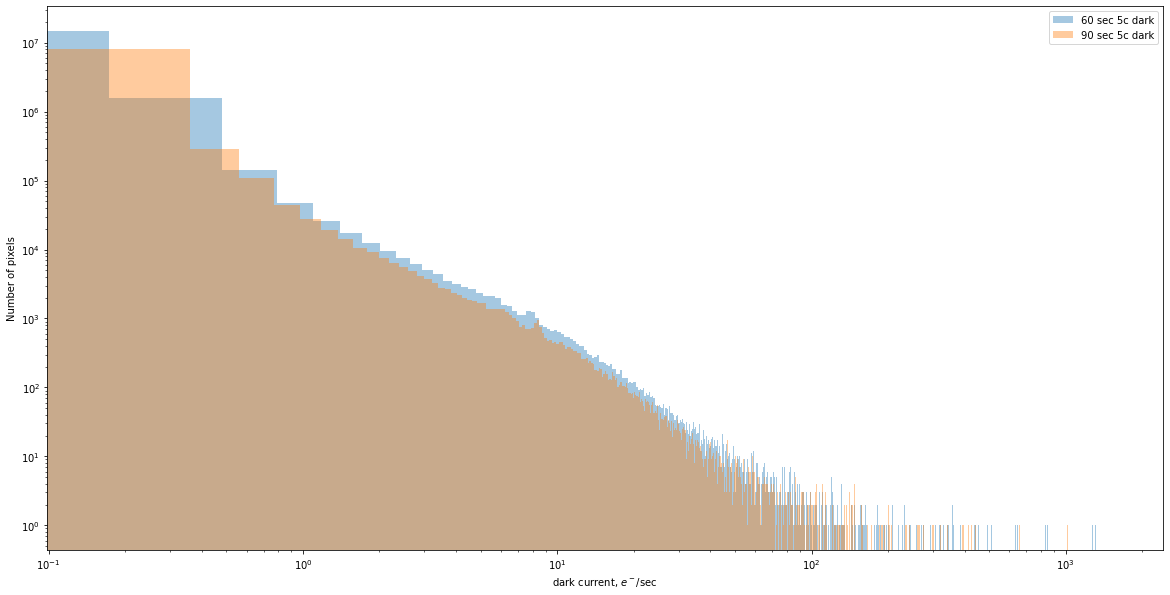

In [75]:
import matplotlib.pyplot as plt
from astropy.units import electron
from astropy.visualization import hist
dark1 = CCDData.read(REDUCED_PATH / "combined_dark_5c_60s_mean.fit", unit=adu).multiply(1.42 * electron / adu).divide(60*second)
dark2 = CCDData.read(REDUCED_PATH / "combined_dark_5c_90s_mean.fit", unit=adu).multiply(1.42 * electron / adu).divide(90*second)

plt.figure(figsize=(20, 10))

hist(dark1.data.flatten(), bins=5000, density=False, label='60 sec 5c dark', alpha=0.4)
hist(dark2.data.flatten(), bins=5000, density=False, label='90 sec 5c dark', alpha=0.4)
plt.xlabel('dark current, $e^-$/sec')
plt.ylabel('Number of pixels')
plt.loglog()
plt.legend();

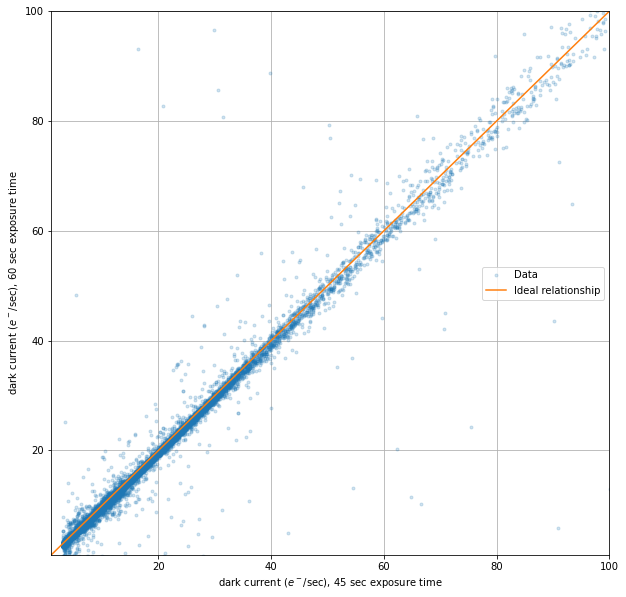

In [92]:
hot_pixels = (dark2.data > 3)
plt.figure(figsize=(10, 10))
plt.plot(dark2.data[hot_pixels].flatten(), dark1.data[hot_pixels].flatten(), '.', alpha=0.2, label='Data')
plt.xlabel("dark current ($e^-$/sec), 45 sec exposure time")
plt.ylabel("dark current ($e^-$/sec), 60 sec exposure time")
plt.xlim((1, 100))
plt.ylim((1, 100))
plt.plot([0, 100], [0, 100], label='Ideal relationship')
plt.grid()
plt.legend();

In [93]:
from astropy.units import dimensionless_unscaled

as_ccd = CCDData(data=hot_pixels.astype("uint8"), unit=dimensionless_unscaled)
as_ccd.header["imagetyp"] = "dark mask"
as_ccd.write(REDUCED_PATH / "dark_current_mask.fit")

print(f"Hot pixels in mask: {hot_pixels.sum()}")
print(f"Percent of total pixels: {hot_pixels.sum()/len(dark1.data.flatten()) * 100:.2f}%")

Hot pixels in mask: 61520
Percent of total pixels: 0.37%


In [79]:
from ccdproc import ccdmask

flat1 = REDUCED_PATH / "combined_flat_15C_median_jun2022_15C_bias.fit"
flat2 = REDUCED_PATH / "combined_flat_12C_median_jul2022.fit"
flat1_ccd = CCDData.read(flat1, units=adu)
flat2_ccd = CCDData.read(flat2, units=adu)

ratio = flat1_ccd.divide(flat2_ccd)
print(f"Ratio of Flats: {ratio.data.mean()}")

flatmask = ccdmask(ratio)
mask_as_ccd = CCDData(data=flatmask.astype("uint8"), unit=dimensionless_unscaled)
mask_as_ccd.header["imagetyp"] = "flat mask"
mask_as_ccd.write(REDUCED_PATH / "flat_mask.fit")

print(f"Number of pixels in flatmask: {mask_as_ccd.data.sum()}")
print(f"Percent of total pixels: {mask_as_ccd.data.sum()/len(flat1.data.flatten()) * 100:.2f}%")

plt.figure(figsize=(12,12), dpi=200)
plt.imshow(flatmask.data, cmap='gray')
plt.colorbar()

Ratio of Flats: 0.9994947910308838
Number of pixels in flatmask: 1212


AttributeError: 'CCDData' object has no attribute 'sum'

In [94]:
combined_mask = mask_as_ccd.data | as_ccd.data
combined_mask = CCDData(data=combined_mask.astype("uint8"), unit=dimensionless_unscaled)
combined_mask.write(REDUCED_PATH / "combined_mask.fit")

Number of pixels in combined mask: 62565
Percent of total pixels: 0.37%


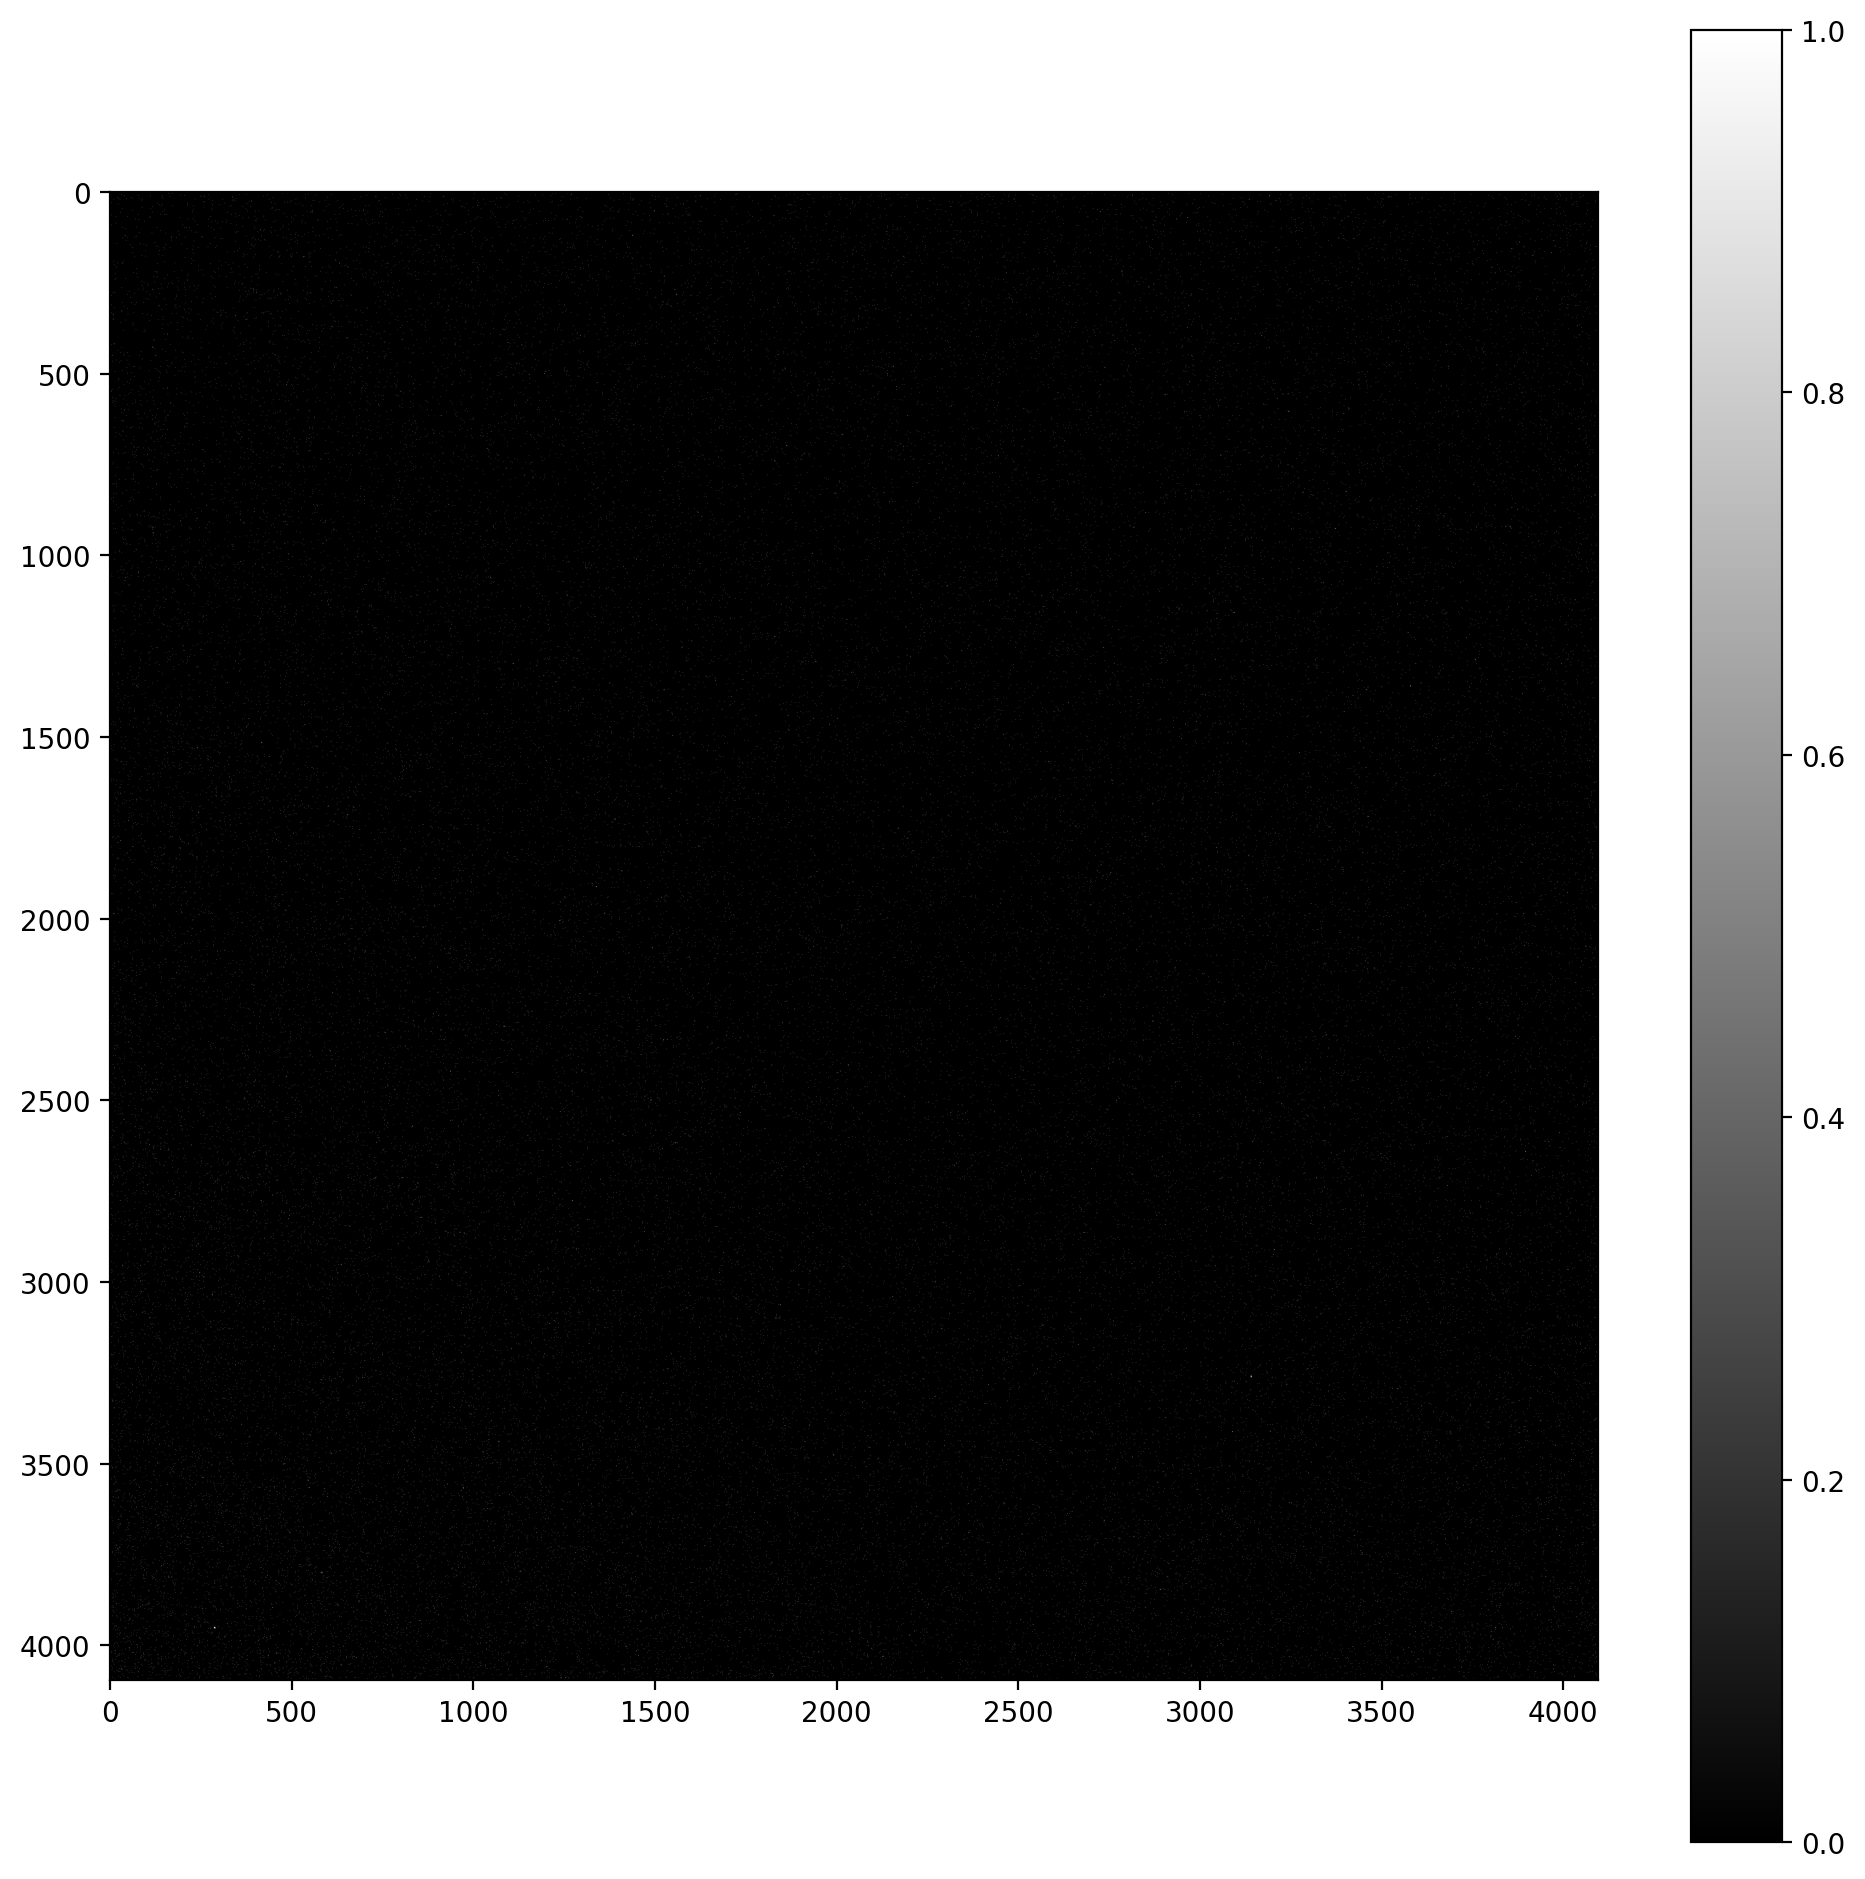

In [95]:
print(f"Number of pixels in combined mask: {combined_mask.data.sum()}")
print(f"Percent of total pixels: {combined_mask.data.sum()/len(flat1_ccd.data.flatten()) * 100:.2f}%")

plt.figure(figsize=(12,12), dpi=200)
plt.imshow(combined_mask.data, cmap='gray')
plt.colorbar()